# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found evidence that suggests Fandango's rating system was biased and dishonest. He found a significant discrepancy between the number of stars displayed to users and the actual rating;

- The actual rating was almost always rounded up to the nearest half-star, a 4.1 rated movie would be rounded off to 4.5 stars and not rounded down to 4.
- In 8% of the ratings analyzed, the rounding up was done to the nearest whole star, so a 4.5 rated movie would be rounded up to 5 stars.
- One movie analyzed was rated 4 stars and rounded up to 5 stars.
- No movie was rated 2 stars or below.

Fandango officals replied saying that the rounding off was caused by a bug in their system rather than biased rounding, in this project we'll analyze more recent movie ratings data to determine whether there has been any change in the rating system after Walt Hickey's analysis.

# Import packages and read in csv files

In [2]:
import pandas as pd

pd.options.display.max_columns = 100 

previous = pd.read_csv('fandango_score_comparison.csv')
after = pd.read_csv('movie_ratings_16_17.csv')

# Explore previous and after dataset

In [3]:
previous.head(5)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,1.10,2.35,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,1.45,1.70,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [4]:
after.head(5)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


# Isolating columns that we're interested in

In [5]:
# we will use .copy() to make copies to avoid any SettingWithCopyWarnings

fandango_previous = previous[['FILM','Fandango_Stars','Fandango_Ratingvalue',
                             'Fandango_votes','Fandango_Difference']].copy()
fandango_after = after[['movie','year','fandango']].copy()

In [6]:
fandango_previous.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [7]:
fandango_after.head(3)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0


The goal of this project is to try to determine if there has been a change in the Fandango rating system after Hickley's analysis, so the population of interest for our anaylsis is made up of all movie ratings on the Fandango website regardless of release date.

With our goal in mind, we'll need to sample the population at two different times; before Hickley's analysis and after. The readme file attached to Hickey's analysis tells us the two main points of his criteria;

1. The movie must have at least 30 fan ratings on the website at the time of sampling (August 24th, 2015)
2. The movie must have had tickets on sale in 2015

From the criteria above, its safe to say the sampling was not done at random. Every movie listed on the Fandango website at the time of sampling did not recieve an equal opportunity to be sampled; if the movie did not have 30 fan ratings it was not included, and any movie that did not sell tickets (red-box/straight to dvd only type movies) were not included. This leads us to believe the sample is not representative (large sampling error)  to the population.

The sampling conditions for our other sample is;

1. The movie must have been released in or after 2016
2. The movie must have had a considerable amount number of votes and reviews

This sample is prone to temporal trends and is unlikely to be representative of our populations interests. Because the authors of these samples had certain research questions in mind when sampling both data sets, along with specific criteria, the sampling they preformed is known as purposive sampling also referred to as a judgmental sample - a type of nonprobability sample.  

# Changing the Goal of our Analysis

Setbacks are common in practical data analysis, sometimes you collect data only to find out you have not found exactly what you need. When setbacks occur you should not give up on the data you have collected and the research you have done altogether, instead you should look for workarounds that are good enough to carry out the tasks at hand. Because of the pitfalls in the samples we outlined above, our new goal will be to determine whether there is any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

# Isolating the Samples We Need

To reiterate, our new goal is to describe and compare;

- All Fandango's ratings for popular movies released in 2015
- All Fandango's ratings for popular movies released in 2016

As a data scientist, often times team members or managers from non-tech teams will ask for analysis on various topics asking for example; "Which type of customer is the best?" or in our case "What are the ratings for the most popular movies ?". Terms like "best" and "popular" do not give us much criteria to work with to finding answers to these questions which is why we use proxies or reach out to those team members/managers to clarify exactly what criteria fits "best" and "most popular".

For our case, we'll be using Hickey's benchmark of 30 fan ratings and consider a movie "popular" only if it has 30 fan ratings or more on Fandango.

In [8]:
# using sample to get 10 samples from data set with a random_state of 1 
fandango_after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


In [11]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [15]:
fandango_previous['FILM'].sample(10, random_state = 1)

98                                      Get Hard (2015)
66                                      The Gift (2015)
53                                   Hot Pursuit (2015)
75                                   San Andreas (2015)
121               The Stanford Prison Experiment (2015)
74     The Hobbit: The Battle of the Five Armies (2014)
119                                      Phoenix (2015)
128         Mission: Impossible â€“ Rogue Nation (2015)
44                  Kingsman: The Secret Service (2015)
58                                   Seventh Son (2015)
Name: FILM, dtype: object

As we can see above, we have movies that were not released in 2015 and 2016 - because of this we need to isolate movies from 2015 into a seperate data set as well as movies from 2016 in another seperate data set and then use these two new data sets to perform our analysis.

# Isolating movies from 2015 only within Hickey's data set

In [16]:
fandango_previous['FILM'].head(3)

0    Avengers: Age of Ultron (2015)
1                 Cinderella (2015)
2                    Ant-Man (2015)
Name: FILM, dtype: object

In [17]:
fandango_previous.columns

Index(['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
       'Fandango_Difference'],
      dtype='object')

Above we see that there is no year column within Hickey's data set, instead the year of the movie is within the FILM column after the movie title and its inside parentheses.

Below we will add a new column 'Year' and use a regular expression to pull out the year from the FILM column.

In [18]:
import re 

fandango_previous['Year'] = fandango_previous['FILM'].str.extract(r'\((.+?)\)')

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()


In [19]:
fandango_previous.columns

Index(['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
       'Fandango_Difference', 'Year'],
      dtype='object')

In [20]:
fandango_previous['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [21]:
# create new data set with only movies released from 2015 (129 total)
fandango_2015 = fandango_previous[fandango_previous['Year'] == '2015'].copy()

In [22]:
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

# Isolating movies from 2016 only with fandango_after data set

In [23]:
fandango_after.columns

Index(['movie', 'year', 'fandango'], dtype='object')

In [24]:
fandango_after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [26]:
fandango_2016 = fandango_after[fandango_after['year'] == 2016].copy()

In [27]:
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

We now have two new data sets; fandango_2015 which is only movies released in 2015 from Hickley's data set, and fandango_2016 which is only movies released in 2016 from our other data set.

# Comparing Distribution Shapes for 2015 and 2016

Now that we have our two data sets, we can continue with our goal of determining whether there's any difference between Fandango's ratings for popular movies in 2015 and the Fandango ratings for popular movies in 2016.

We'll generate a two kernel density plot which will help us visualize the distribution of data over our time periods.

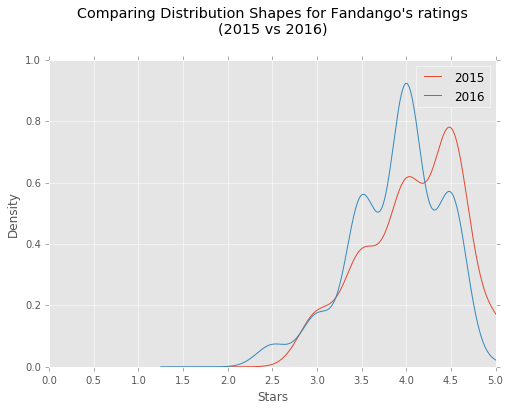

In [28]:
# import matplotlib.pyplot and arange from numpy
import matplotlib.pyplot as plt
from numpy import arange
# do not forget in jupyter we need to pass in %matplotlib inline
%matplotlib inline

plt.style.use('ggplot')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015', legend=True, figsize=(8,5.5))
fandango_2016['fandango'].plot.kde(label = '2016', legend=True)

plt.title("Comparing Distribution Shapes for Fandango's ratings\n(2015 vs 2016)",
         y=1.07)

plt.xlabel('Stars')
# set xlim for range 0-5 since ratings start at 0 and end at 5
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.show()

Lets answer some questions based on the kernel density plots above.

- What is the shape of each distribution ?

Both distributions are left skewed meaning the tail is on the left side.

- How do their shapes compare ?

The 2015 shape is slighty more favored towards higher ratings around the 4.5-5 mark, the 2016 shape has a higher top towards ratings around the high 3s-4.0 ratings mark.

- Can we see any evidence on the graph that suggest there is indeed a change between the ratings from 2015-2016 ?

We can see that in 2015 there were much more ratings over 4.0 especially around the 4.3-4.6 range, in 2016 there were a lot less ratings over 4.0 so there is evidence that there was a shift in the fandango rating system for popular movies.

# Comparing Relative Frequencies

Because the samples have different number of movies, we can normalize the tables and take a look at percentages instead.

In [32]:
print('2015' + '\n' + '---')

fandango_2015['Fandango_Stars'].value_counts(normalize=True).sort_index()*100

2015
---


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [33]:
print('2016' + '\n' + '---')

fandango_2016['fandango'].value_counts(normalize=True).sort_index()*100

2016
---


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2015;

- 6.97% of the movies in the sample recieved a rating of 5 stars
- 37.98% of the movies in the sample recieved a rating of 4.5 stars 
- 28.68% of the movies in the sample recieved a rating of 4.0 stars
- 17.82% of the movies in the sample recieved a rating of 3.5 stars

In 2016;

- 5 star ratings were down from 6.97% to less than 1% (0.523%) a massive drop off
- 4.5 star ratings were down from 37.98% to 24.6%
- 4.0 star ratings were up to a whopping 40.3% from 28.6%
- 3.5 star ratings were up to 24.08% from 17.8%
- 2.5 star ratings were added and made up 3.1% of the movies

It is clear that there is a difference between the two distributions. It seems like ratings were adjusted and re distributed into lower ratings, especially at the 4.0 star rating mark which we covered in the shape of the distributions. There is a good chance that the 6.97% of movies that recieved a 5 star rating were re distributed between the 4.0 and 4.5 star rating mark.

# Determining the Direction of the Change